# Fashion MNIST

This notebook contains a detailed, annotated project where we'll be building a classifier for the Forest Cover Types dataset.  Our goal will be to build a classification model that can accurately predict the article of clothing based on the image.

More information about the dataset is on the [scikit-learn website](https://scikit-learn.org/stable/datasets/real_world.html#covtype-dataset).

There's one issue with this data: there's a lot of it (581,012 observations), and the target classes are super imbalanced.  We don't want to deal with the class imbalance question right now, so we'll load the data, and resample just 2,500 from each target class.  Then we'll generate train-test splits for use later.

In [1]:
from collections import Counter

import pandas as pd
from sklearn.datasets import fetch_covtype, load_digits
from sklearn.model_selection import train_test_split

x, y = fetch_covtype(return_X_y=True)
# x, y = load_digits(return_X_y=True)
print("The classes are super imbalanced:")
print(Counter(y))

where = (y==1) | (y==2)
x = x[where]
y = y[where]

frame = pd.DataFrame(x)
frame["TARGET"] = y
frame = frame.groupby("TARGET").sample(frac=1).groupby("TARGET").head(n=100_000)
x = frame.drop(columns=["TARGET"]).values
y = frame["TARGET"].values
del frame

print("\nOur data is now much more balanced:")
print(Counter(y))

train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, stratify=y)

The classes are super imbalanced:
Counter({2: 283301, 1: 211840, 3: 35754, 7: 20510, 6: 17367, 5: 9493, 4: 2747})

Our data is now much more balanced:
Counter({1: 100000, 2: 100000})


Our features are now arrays where each column corresponds to a specific pixel location in the original images.

Out first inclination might be to do some exploration and investigate the relationships between different features and our target variable.  This won't be feasible for this dataset: we have a lot of features, and asking "how does this one pixel relate to the target value" isn't meaningful to us.  So we're not going to be doing a lot of manua data exploration here.  But, we can still do some investigation, we just have to think about it differently.  A natural question we have might be: how well-separated are my different classes? I.e., is there a lot of overlap between, say, shirts and dresses? We could attempt to answer this question mathematically by doing something like "the average of pairwise Euclidean distance between the vectors for shirts and dresses," but I find there's a much better way: just plot the data.

But how do you plot 784-dimensional data?  There are a lot of clever ways, but here are two that I like:
- Dimensionality reduction.  Run something like PCA or SVD or T-SNE to get the data down to 2 dimensions, then make a scatterplot.
- Use a *parallel coordinates plot.*  This treats each observation basically like a time series.  Each feature is treated like an X coordinate (evenly spaced; so the first feature would be at X=0, the second feature at X=1, etc), and the feature values are treated like y-values.  So if I have an observation with three features, say `[4, 7, 1]`, I would make a line plot passing through the points `(0, 4)`, `(1, 7)`, and `(2, 1)`.  You overlay these lines for every observation.  I tend to find these a bit hard to read at times, but other people find them very useful.

Let's see both of these in action.  If we look at our data and see that there's no clear separation, we might learn that we picked bad features, or need to engineer some new ones.

# Exploration: Dimensionality Reduction

Dimensionality reduction is a huge topic, but I'll boil it down to the essentials you actually need.  There are really only three kinds of dimensionality reduction, and five algorithms, you need to know about.

1. Linear dimensionality reduction, usually implemented with matrix factorization.  This essentially just rotates and scales your data.
    - Singular Value Decomposition and Principle Component Analysis are the two algorithms to know here.  Both are very fast and very useful.  PCA is actually built on top of SVD, so there isn't a lot of difference between the two mathematically.  In practice, PCA tends to perform a little better (mostly on smaller datasets, in my experience; on large datasets, there's almost no difference), but you should *never* run PCA on large sparse matrices.  PCA will destroy the sparsity, which can cause your program to try to allocate a few hundred gigabytes of RAM (yes, even for fairly simple problems).  SVD does not destroy sparsity, so use it if your data is in a sparse array format.
    - These algorithms are often described as preserving *global structure.*  I.e., everything stays in about the same place relative to everything else.
    - These algorithms usually have nice, closed-form/analytic solutions, so they run very fast and their performance is very predictable.
    - There's also Kernel PCA, which I won't cover, but is worth checking out.
2. Non-linear dimensionality reduction.
    - T-distributed Stochastic Neighbor Embedding (T-SNE) and Uniform Manifold Approximation and Projection (UMAP) are the two to know here.  UMAP is, in my experience, just plain better than T-SNE in every way, but not by such a huge margin that you shouldn't use T-SNE.  T-SNE's big benefit is that it's already implemented in scikit-learn, while UMAP is implemented in its own library (which is fully compatible with scikit-learn).
    - These algorithms try to preserve *local structure.*  Things should be in a similar location *to the things near them,* but not necessarily thing far away from them, after doing the dimensionality reduction.  I find that they make much nicer visualizations for a lot of datasets, and they have a lot more options to precisely control how they'll work with your particular data.  Preserving local structure can also be a huge benefit for certain kinds of models, e.g., clustering models or K-Nearest Neighbors.
    - These algorithms are slower, though.  *Much* slower in T-SNE's case.  They do not have a closed-form/analytic solution, so they need to do a lot of iterative updates to their guesses.
3. Autoencoders.
    - These are a specialized kind of neural network that tries to find a low-dimensional approximation for your original data that allows the best reconstruction.  E.g.: find a 50 dimensional representation of the Fashion MNIST data that, when I feed it into a dedicated "reconstruction" model, gets as close as possible to the origina data.
    - Another way of thinking about it: autoencoders are trying to find the least lossy compression of your data, given a certain number of target dimensions.
    - Autoencoders are really a kind of model rather than a specific one, but they all accomplish the same basic goal I just described.
    - Autoencoders are very cool, and don't fit neatly into the linear/non-linear dichotomy.  But we're also not going to cover them here.

Let's use SVD, PCA, and UMAP.  UMAP needs to be installed separately, but since it's faster and generally better than T-SNE, and uses the exact same transformer interface as everything in scikit-learn, it's well worth the extra step.  Install UMAP with:

```bash
conda install -c conda-forge umap-learn
```

And then import it with

```python
import umap
```

(there's already another library that has the name "UMAP," and is totally unrelated to the library we want, so we have to install it with the name `umap-learn`)

Running PCA
CPU times: total: 14.2 s
Wall time: 6.32 s

Running SVD
CPU times: total: 9.88 s
Wall time: 3.49 s

Running UMAP
UMAP(n_jobs=10, verbose=1)
Tue Jul 19 16:44:50 2022 Construct fuzzy simplicial set
Tue Jul 19 16:44:50 2022 Finding Nearest Neighbors
Tue Jul 19 16:44:50 2022 Building RP forest with 25 trees
Tue Jul 19 16:44:51 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Tue Jul 19 16:45:05 2022 Finished Nearest Neighbor Search
Tue Jul 19 16:45:07 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Jul 19 16:46:42 2022 Finished embedding
CPU times: total: 12min 3s
Wall time: 1min 51s
Plotting.


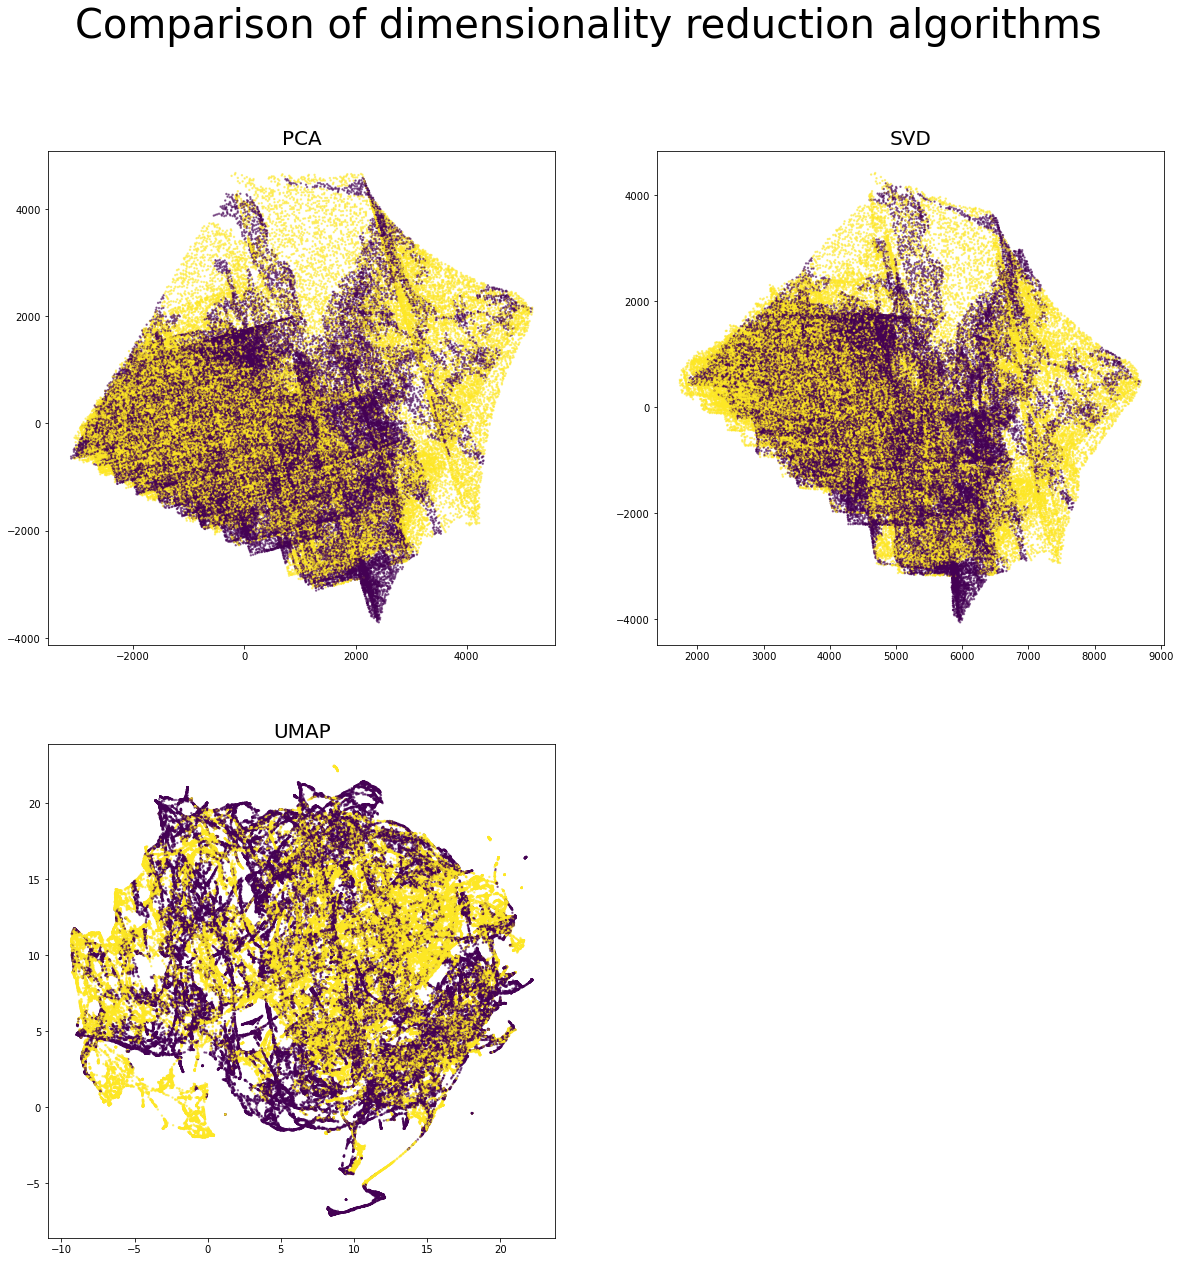

In [2]:
# !conda install --yes -c conda-forge umap-learn

# sklearn implements a specific version of SVD called TruncatedSVD.
# You don't need to worry about exactly what the "truncated" part means,
# but I encourage you to read into it a bit.
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP

# Dimensionality reductions.
# Transformers have .fit(), .transform(), and .fit_transform()
# methods (among others).  .fit_transform(x, y) is the same as
# .fit(x, y).transform(x, y).  (most transformers don't use the y
# values, but you can pass them to all transformers; this is just
# so the API stays consistent).
print("Running PCA")
%time pca = PCA(n_components=2).fit_transform(train_x)
print("\nRunning SVD")
%time svd = TruncatedSVD(n_components=2).fit_transform(train_x)

# UMAP has a *lot* more options, but we'll use the defaults.  Except for
# n_jobs, which we'll set to 4; this will allow UMAP to parallelize parts
# of its code and run faster.
print("\nRunning UMAP")
%time umap = UMAP(n_components=2, n_jobs=10, verbose=1).fit_transform(train_x)

print("Plotting.")
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20,20))
fig.suptitle("Comparison of dimensionality reduction algorithms", fontsize=40)
axes[0,0].scatter(pca[:,0], pca[:,1], s=2, alpha=0.5, c=train_y)
axes[0,0].set_title("PCA", fontsize=20)

axes[0,1].scatter(svd[:,0], svd[:,1], s=2, alpha=0.5, c=train_y)
axes[0,1].set_title("SVD", fontsize=20)

axes[1,0].scatter(umap[:,0], umap[:,1], s=2, alpha=0.5, c=train_y)
axes[1,0].set_title("UMAP", fontsize=20)

axes[1,1].set_axis_off()
plt.show()

The PCA and SVD results are extremely similar; the SVD one is basically just a "squished" version of PCA's.  The way that PCA is implemented is essentially "SVD with some extra steps," so this isn't super surprising.  On larger datasets like this, the two tend to be nearly indistinguishable, but on smaller datasets the differences can be a lot more pronounced.  Note that the UMAP ran a lot more slowly; UMAP scales more poorly with the total number of observations than either PCA or SVD.  (I have seen it scale better with large numbers of features, though; for a dataset of a few ten thousand observations and about a thousand features, UMAP was actually faster than PCA, but still slower than SVD).  But, the UMAP data also has a very qualitatively different look, and seems to be achieving a slightly better separation between our classes.  This sort of "stringy" look is pretty typical of UMAP, due to the mathematical details of how it works.

As a brief aside, the UMAP projection does look a lot like the PCA/SVD ones for this dataset, but that is not generally going to be the case.  UMAP often looks very different, usually with more "clumps," where PCA and SVD tend to look "fuzzier."  I suspect that this particular dataset has a very high and uniform density of points, which is probably why the three algorithms all look very similar; UMAP tends to exaggerate "breaks" and "clusters" in the data.

From these plots, the data looks a bit messy, but I think--especially with the UMAP projection--we have enough separation between our classes to proceed.

# Exploration: Parallel coordinate plot

Let's look at a parallel coordinate plot now.  This can be done in pure Matplotlib and is pretty straightforward.  The only things we need to be careful about are making sure our line thickness and transparency are low enough that we can see actual trends!

Plotting for class 1.
Plotting for class 2.
Rendering plot.


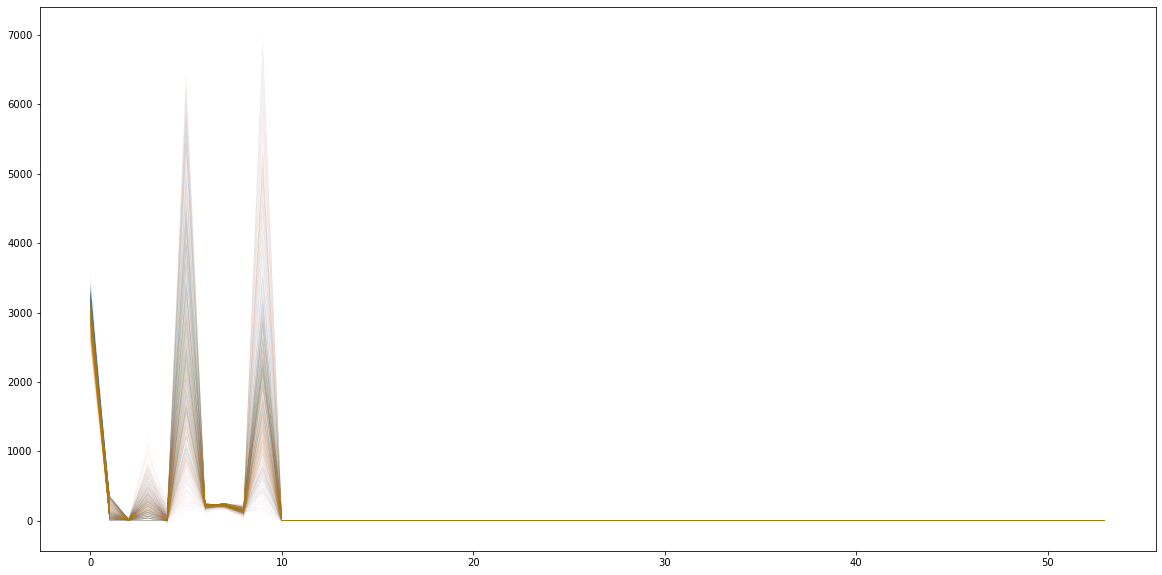

CPU times: total: 1.02 s
Wall time: 1.01 s


In [3]:
%%time
# manually control the colors
from matplotlib import cm
colors = cm.get_cmap("tab10").colors

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

fig, ax = plt.subplots(figsize=(20, 10))
for i in set(train_y):
    print(f"Plotting for class {i}.")
    
    # Sample 500 random vectors.
    to_plot = train_x[train_y == i]
    to_plot = rng.choice(to_plot, size=500, axis=0)
    
    # .T = transpose.  If you pass an array, each *column* gets plotted
    # independently.  But we want *rows* to be plotted.  So just transpose
    # the matrix.
    ax.plot(to_plot.T, linewidth=0.1, alpha=0.1, c=colors[i - 1])
print("Rendering plot.")
plt.show()

Hm.  That's super ugly and hard to read.  Here's a thought: what if we do this to the SVD-transformed data?  The SVD features might give us better visual separation.  And, we know from how PCA works that we can probably throw out all but the top few features--let's pick 50 features, somewhat at random.

Plotting for class 1.
Plotting for class 2.


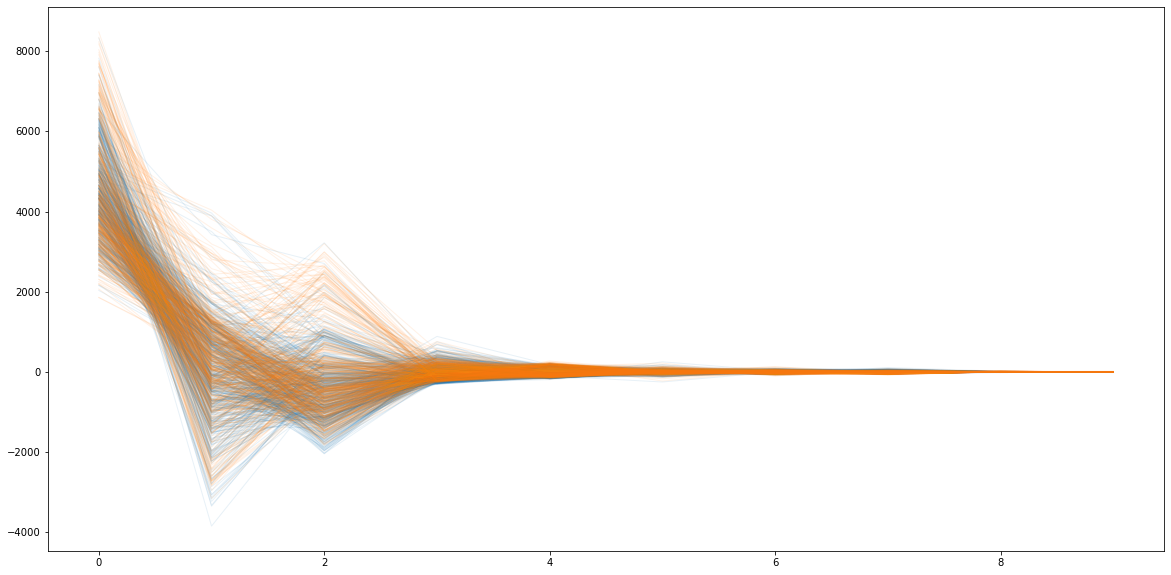

CPU times: total: 14.6 s
Wall time: 7.25 s


In [4]:
%%time
from matplotlib import cm
colors = cm.get_cmap("tab10").colors

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

# print("Running SVD.")
svd = TruncatedSVD(n_components=10).fit_transform(train_x)
fig, ax = plt.subplots(figsize=(20, 10))
for i in set(train_y):
    print(f"Plotting for class {i}.")
    to_plot = svd[train_y == i]
    to_plot = rng.choice(to_plot, size=500, axis=0)
    ax.plot(to_plot.T, linewidth=1, alpha=0.1, c=colors[i - 1])
plt.show()

That's a lot better, but still not great; the colors overlap with each other a lot.  We can see some areas where they clearly difer, though, which is good, and indicates we probably have some good separation along a few major dimensions.

This hard-to-read nature is the big reason I don't tend to use parallel coordinate plots--they tend to get very hard to read, especially if you have a lot of classes, or if you don't have a trivially obvious separation between classes.  This might happen if your two classes don't each form a single, cohesive cluster of points, but maybe you have much more complex, non-linear, "pock-marked" distributions.

# Let's fit some models

We've taken a few different looks at our data and, to my eyes, there's enough distinction between the different classes that I don't see any red flags.  So, let's do the thing all machine learning engineers secretly do: just throw a model at it without worrying too much, and see how well it works.  Personally, I like SGDClassifiers; they're good for binary classification, have a lot of settings we can tweak, and tend to be pretty fast.

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

# "clf" = abbreviation for "classifier"; it's an abbreviation I use a lot.
# tol=1e-5 just makes sure this model waits for a pretty darn good answer
# before it says it's done.
%time clf = SGDClassifier(tol=1e-5, random_state=0).fit(train_x, train_y)
preds = clf.predict(test_x)
print(f"SGD Classifier accuracy on test set: {metrics.accuracy_score(test_y, preds):.2%}")

CPU times: total: 22.2 s
Wall time: 22.1 s
SGD Classifier accuracy on test set: 59.58%


### A rare digression to talk about very important math

A very important note: I've used `random_state=0` in the above code.  Let's talk about this, and why I think you should basically never use `random_state` in production code.

The SGD classifier is a *linear model,* meaning it's trying to find a linear equation (y = a0 + a1x1 + a2x2 + ...) that best separates the data.  The SGD Classifier operates more or less like so (this will be highly simplified):
1. Take an initial, completely random guess as to what the right coefficients and intercept are.
2. Use this random guess to make predictions on a batch of observations.  Score yourself using a *loss function* (this is different from a *scoring funcion*: the loss function is used by the model to find good weights, but the scoring function is used by a human to assess the quality of the model's predictions; there are some mathematical differences as well, like loss functions *must* be differentiable).
3. Do some calculus: take the derivative of your loss function with respect to your weights, and average the results toegther for the batch of observations.
4. Use those average derivatives to "nudge" the weights in the direction that will minimize your loss function.
5. Rinse and repeat 2-4 until your updates are so small they don't matter.

Or, roughly equivalently: the SGD Classifier is trying to find coefficients that will minimize a *global minimum* of a chosen loss function, using *Stochastic Gradient Descent (SGD).*  If you have nice data and a good choice of loss function, you might get what's called a *convex optimization problem.*  This means that there is one, and only one, true minimum value for the loss function, and no matter where you start (the random guess in step 1), you will always converge on that "true answer."

But most data is not nice, and has *local minima.*  A local minimum is a set (or range) of coefficient values where any small changes to them make your loss function worse, but where a better set of coefficients exists somewhere far away.  (e.g., over a metaphorical "hill": you'd have to "push your coefficients up and over a hill," during which time your loss function keeps getting worse and worse, and the model doesn't like that.

So, back to `random_state`.  This sets the random seed for the model (normally a new seed is selected every time you hit "run"), which guarantees that the model picks the same initial guess and gets to the same final answer every time.  But: what if that initial guess is going to lead it to a bad local minimum?  You may never know if you use a fixed random seed.

My advice for best practices is this: with models like SGD Classifiers and regressors, or anything that uses gradients and numeric solvers to try to minimize a problem, *don't use fixed random seeds.*  These models tend to be quite fast compared to other options, so you *should* try to run them a few times.  If you get very similar answers each time, then all is well.  If you get lots of variation in your anwers from run to run, then you need to make some changes, because your model is very unstable. You might need to swap to a different algorithm, or do some aggressive parameter tuning (see below), or revisit your feature engineering.

When I ran the above cell a few different times during the creation of this notebook, I saw the accuracy jump by as much as 12%.  Usually I want this amount to be not much bigger than 0.5%.  So, I'm going to use a random seed for this notebook only because it makes it easier to demonstrate a few other points I'm trying to make.  But you should *never* start with a fixed random seed, and you should think long and hard about picking a fixed seed at any point in your projects; *repeatability does not imply correctness.*

## Make it run faster!

Hm.  notice how long that took to run--about 20 seconds on my computer.  That's not too bad, but can we make this run faster?  Yes!

- Use fewer observations.
    - There's some interesting work out there on how to find "core sets" (that might not be exactly the term most people use), which are very small subsets of the data that allow the model to learn the same overall patterns.
    - There's also outlier removal--but we rarely do this.  Defining an "outlier" in very high-dimensional space is actually harder than you might expect, and ML models don't interact with outliers in the same way that classical statistical models do (*especially* classification models).  Plus, a few outliers in a dataset of a few hundred thousand points are hardly worth worrying about, and if it's more than a few outliers, they're probably not outliers any more.  Those points probably represent a valid pattern within your data that you should try to capture.
- Use fewer features.
    - We can remove features.  E.g., we can say "remove any feature from the dataset whose variance is less than X," where X is some threshold.  Low-variance features almost never help us on their own, and they rarely help even when combined with other features in practice.
    - Run a dimensionality reduction tool like Singular Value Decomposition or PCA or UMAP.
- Parallelize the model.
    - Some--but not all--models have steps that can be run in parallel, for very easy speedups.  SGD Classifiers, when there are only two classes, can't be parallelized in scikit-learn, but other models can.  Look for an `n_jobs` parameter in the model's documentation.
- Use a faster model.
    - Some models are inherently slower or faster than others.  If one model is too slow, try a faster one!
    - SGD Classifiers tend to be pretty fast.  But there are faster models like Naive Bayes, and slower models like gradient boosted ensembles of trees.
- Change some of the mode's parameters.
    - Some model parameters can effect how slow or fast the model is.
    - Usually you only tweak parameters for speed in extreme cases, so we won't do that here; usually you're tweaking parameters for better accuracy.

Using fewer features is going to be our best option here, though if we were using a model that supported parallelism via an `n_jobs` argument, that would be even easier.  By using fewer features, though, we're going to give up some accuracy; whether the amount of accuracy we lose is worth the extra speed is something you have to decide on a case-by-case basis.

Let's see what doing some feature selection would look like.  We'll use a simple f-test (i.e. an ANOVA) between the features and the target variable, and only keep the 25 highest-scoring features.  (this will roughly halve our number of features).  Scikit-learn gives us some tools to do different parts of this, but we need to assemble the ourselves:
- A tool for only keeping the K features with the best score, using a user-configurable scoring function.
- A function for calculating the f-score of some data.

In [6]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest
from sklearn import metrics

# Select just the 5 best features.  I picked that number pretty arbitrarily.
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(train_x, train_y)
train_x_transformed = selector.transform(train_x)
test_x_transformed = selector.transform(test_x)

%time clf = SGDClassifier(tol=1e-5, random_state=0).fit(train_x_transformed, train_y)
preds = clf.predict(test_x_transformed)

print("Test set performance:")
print(f"Accuracy: {metrics.accuracy_score(test_y, preds):.2%}")

C:\Users\andersonh\Miniconda3\envs\PythonForDataAnalysis\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [14 18 27 28 50] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\andersonh\Miniconda3\envs\PythonForDataAnalysis\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


CPU times: total: 11 s
Wall time: 11 s
Test set performance:
Accuracy: 50.02%
CPU times: total: 11.2 s
Wall time: 11.2 s


Our speed went up, but our accuracy dropped.  This shouldn't be too surprising, since by removing features, we're removing information from the dataset that our model might be able to learn from.  This speed-accuracy tradeoff is one you'll have to make all the time when doing data work.

Dimensionality reduction looks almost exactly the same as the above approach.  Let's use SVD, and again pick only the top 25 features.

In [7]:
%%time
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics

# Note how almost nothing about the code has changed--transformers are drop-in
# replacements for each other, just with different parameters and different imports.
selector = TruncatedSVD(n_components=10)
selector.fit(train_x, train_y)
train_x_tranformed = selector.transform(train_x)
test_x_tranformed = selector.transform(test_x)

%time clf = SGDClassifier(tol=1e-5, random_state=0).fit(train_x_tranformed, train_y)
preds = clf.predict(test_x_tranformed)

print("Test set performance:")
print(f"Accuracy: {metrics.accuracy_score(test_y, preds):.2%}")

CPU times: total: 9.83 s
Wall time: 9.82 s
Test set performance:
Accuracy: 56.16%
CPU times: total: 23.2 s
Wall time: 16 s


Like before, we gain some speed, but this time, we didn't lose much accuracy!  Note that our total program time went up a little bit, though; our model fits faster, but the SVD step takes up some extra time.

Let's switch to PCA.  Since each principle component captures some proportion of the overall variance in the data, we can pick "however many dimensions preserves 90% of the variance" (or some other threshold).  We do this by passing a float, between 0 and 1, to the PCA constructor.  This tells it how much _variance_ to keep; it will then select the smallest number of components that keep at least that proportion of the origina variance.  (Statistics people: this is the same thing you might do by hand by looking at a Scree plot).

In [8]:
%%time
from sklearn.decomposition import PCA
from sklearn import metrics

# "however many components keep 90% of the original variance"
selector = PCA(n_components=0.99)
selector.fit(train_x, train_y)
train_x_tranformed = selector.transform(train_x)
test_x_tranformed = selector.transform(test_x)
print(f"PCA kept {train_x_tranformed.shape[1]} components.")

%time clf = SGDClassifier(tol=1e-5, random_state=0).fit(train_x_tranformed, train_y)
preds = clf.predict(test_x_tranformed)

print("Test set performance:")
print(f"Accuracy: {metrics.accuracy_score(test_y, preds):.2%}")

PCA kept 4 components.
CPU times: total: 4.19 s
Wall time: 3.63 s
Test set performance:
Accuracy: 65.13%
CPU times: total: 5.69 s
Wall time: 4.02 s


In this case, our speed went up, but our accuracy is still crap.  I guess there's something about this data that just mean PCA/SVD give us really crappy features for regression!

There are a lot of other ways we can do feature selection, e.g., forward and backward selection, recursive feature elimination, selecting based on a model's importance scores, etc; feature selection is a huge and very deep area.

## Make it more accurate!

Our accuracy was pretty dang good (70%+), but can we do better?  If so, how?  Like with speed, we have a few big ways we can tweak things.

- Feature engineering.  We can create new features based on the ones we have, e.g., adding interaction terms.  How much this affects your results depends a bit on your model; some models like linear regressions are very sensitive to feature engineering, but models like a random forest are less sensitive to it.
- Model parameters.  We've seen how we can pass some arguments/settings to PCA and UMAP; we can pass similar arguments to each model to change how it behaves.  These are usually called *hyperparameters.*  Importantly, these parameters *cannot be learned from the data,* and have to be chosen ahead of time.  In a lot of cases, we can't really know or reason about what a good value will be.

We've already done a bit of feature engineering with SVD/PCA/UMAP, and some feature selection.  But let's take a look at some of the other tools in scikit-learn for *creating* features.  I'll just focus on one: `sklearn.preprocessing.PolynomialFeatures()`, which lets us create higher-order terms.  (e.g. interaction terms and quadratic/cubic/etc terms).  There are a lot of others (the `SplineTransformer()` is especially cool), but you'll have to explore them on your own time.

Let's apply the following steps:
- Generate all second-order features, including interaction features.  This will add a *lot* (almost a thousand) new features.
- Remove any features that have constant values.
- Run the `SelectKBest` tool to select the 20 best features.  (a number I've chosen pretty much at random)
- Run a StandardScaler() to scale all features to have an average of zero and a standard deviation of 1.  (we probably should have been doing this all along--SGD Classifier is a *scale sensitive* model--but I didn't want to introduce that concept yet).
- Fit our SGD Classifier.

In [9]:
%%time
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import metrics


poly = PolynomialFeatures()
poly.fit(train_x)
train_x_transformed = poly.transform(train_x)
test_x_transformed = poly.transform(test_x)
print(f"After adding polynomial features, there are {train_x_transformed.shape[1]:,} features.")

# default behavior is to remove constant features
var = VarianceThreshold()
var.fit(train_x_transformed, train_y)
train_x_transformed = var.transform(train_x_transformed)
test_x_transformed = var.transform(test_x_transformed)
print(f"After variance thresholding, there are {train_x_transformed.shape[1]:,} features.")

scaler = StandardScaler()
scaler.fit(train_x_transformed, train_y)
train_x_transformed = scaler.transform(train_x_transformed)
test_x_transformed = scaler.transform(test_x_transformed)
print(f"After scaling features, there are {train_x_transformed.shape[1]:,} features.")

k_best = SelectKBest(score_func=f_classif, k=50)
k_best.fit(train_x_transformed, train_y)
train_x_transformed = k_best.transform(train_x_transformed)
test_x_transformed = k_best.transform(test_x_transformed)
print(f"After f-test feature selection, there are {train_x_transformed.shape[1]:,} features.")

clf = SGDClassifier(tol=1e-5, random_state=0)
%time clf.fit(train_x_transformed, train_y)
preds = clf.predict(test_x_transformed)
print(f"Accuracy: {metrics.accuracy_score(test_y, preds):.2%}")

After adding polynomial features, there are 1,540 features.
After variance thresholding, there are 600 features.
After scaling features, there are 600 features.
After f-test feature selection, there are 50 features.
CPU times: total: 4.53 s
Wall time: 4.53 s
Accuracy: 76.12%
CPU times: total: 14.2 s
Wall time: 14.2 s


Hooray!  And we got good accuracy, too, better than any of our previous attempts!  But there's a problem.  What happens if we want to add a new processing step?  Notice that we're doing a lot of bookkeeping to train our different transformers and make sure that the training and testing data gets transformed correctly.  All this repetitive bookkeeping means it's very easy to make a mistake if we add or remove some processing steps.  It also just means we have a lot of nearly-identical lines of code to manage.

Surely, has to be a better way.

And there is!  `Pipeline`s!

`Pipeline`s allow us to very easily compose different data operations.  It does, conceptually, the same thing we just did above, but with much nicer code and much less pointless re-running of the same things over and over and over again.  A `Pipeline` is one of those pesky meta-estimators I mentioned earlier: we give it a bunch of transformers and estimators, and it will combine them into a brand new one.

In [10]:
%%time

from sklearn.pipeline import Pipeline

# Construct a Pipeline by passing a list of ("step_name", Thing()) tuples.
pipe = Pipeline(
    [
        ("interactions", PolynomialFeatures()),
        ("variance thresholding", VarianceThreshold()),
        ("f-test selection", SelectKBest(score_func=f_classif, k=100)),
        ("scaling", StandardScaler()),
        ("clf", SGDClassifier(random_state=0))
    ]
)
pipe.fit(train_x, train_y)
preds = pipe.predict(test_x)
print(f"Test set accuracy: {metrics.accuracy_score(test_y, preds):.2%}")

Test set accuracy: 76.00%
CPU times: total: 10.2 s
Wall time: 10.2 s


Isn't that code so much nicer?  It's also a lot easier to make changes.  If we decide we want to calculate our interactions after doing the f-test, we just move the "interactions" component below the "f-test selection" one.  When we call `.fit()` on this `Pipeline` object, scikit-learn will do the following:

- Call the `.fit()` model of the first step (SVD, in our case), with the exact same arguments we passed to `Pipeline.fit()`.
- Once that has finished, scikit-learn will use the `.transform()` of the first step to transform our input data, and pass that to the `.fit()` method of the next step.
- Rinse and repeat.  Each step gets fit, then used to transform the data, and the transformations are passed on to the next thing as the fitting data.

When we call `.predict()` (or `.predict_proba()`, or `.decision_function()`, etc), scikit-learn will call the `.transform()` methods of all but the final element in the pipeline, inorder, on our input data.  Then it will call `predict()` (or whatever method we tried to call) on the final step, using the output of the transformations as the input data.

It's a bit confusing to describe at first, I admit.  But the above `Pipeline` will do the same thing as the messy code in the preceding cell.  It's less code, it's cleaner, and we now only have a single object we need to worry about in our code!

## Parameter tuning

Now for the big topic: parameter tuning.  Let's focus on just two parameters of the SGD Classifier: the loss function and the regularization strength.  Without getting into too much detail, the loss function is what the model uses to figure out how to update its weights, and the regularization strength limits how big the weights can get (this is to prevent overfitting).  While we can reason about *some* properties of the different options--e.g., we might know that the Hinge loss function is more robust to outliers than Squared Hinge--we can't know in advance what loss function will give us the best *accuracy*.  We also can't know if the effect of the regularization strength differs for each loss function or not.  So how do we pick good values?

Simple: just try a whole bunch of different values and see what gives us the best accuracy.

The basic recipe goes like this:
1. Get a list of the parameters you want to tweak, and the values you want to try out.
2. Take your training dataset, and partition it into some number of smaller "folds."  Let's say three for this example.
3. For every combination of parameter values you've selected, do the following (this is called *cross-validation*):
    a. Pick one of the folds.  Fit your model to *the other two folds.*
    b. Check your model's predictions against the fold you did not train on.
    c. Repeat this for every fold, so that every fold gets used as the held-out/testing fold once.
    d. Average the scores for this combination of parameters across all the different held-out/testing folds.
4. Pick whatever combination of parameters had the highest average score after step 3.
5. Re-fit your mode, with these parameters, to _all_ of your training data, no longer split up into folds.
6. Check your final accuracy scores against your original test set.

That sounds like a lot of steps--because it is--but fortunately we don't have to implement any of the middle steps ourselves.  Scikit-learn has tools to do steps 2-5 for us:
- `sklearn.model_selection.GridSearchCV()`: tries every combination of parameter values that you specify.
- `sklearn.model_selection.RandomizedSearchCV()`: randomly samples from the parameter combinations you provide, rather than trying all of them.
- `sklearn.model_selection.HalvingGridSearchCV()` and `HalvingRandomizedSearchCV()`: use some fancy tricks to check when a combination of parameters is obviously not showing any promise, and then don't bother fully fitting a model with those parameters.  Spend time and effort on the combinations that look good.  (this is still experimental, so I wouldn't use it for serious work just yet).

`GridSearchCV()` is a very brute-force method of finding good prameters.  It's a good choice if you're using a pretty fast model, or only checking a few parameters.  `RandomizedSearchCV()`, because it does random sampling rather than exhaustive searching, is better for when you have a *huge* number of parameters to search.  With some models it's not uncommon to have tens of thousands of combinations you want to check, but you often can't actually check all of them.

All of these can be parallelized, and they absolutely should be.  Parameter tuning is always the bottleneck in my projects; it takes a long time.

Let's see a quick demo of a grid search with the SGD Classifier.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

print("Preprocessing data.")
scaler = StandardScaler()
scaler.fit(train_x)
train_x_transformed = scaler.transform(train_x)
test_x_transformed = scaler.transform(test_x)

# Grid search
clf = GridSearchCV(
    # The base estimator whose parameters we want to tune
    estimator=SGDClassifier(tol=1e-5, random_state=0),
    
    # The specific parameters to tune, and the values to try
    param_grid={
        # max_depth=None is the default value
        "loss": ["hinge", "squared_hinge", "modified_huber", "log", "perceptron"],
        "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    },
    
    # How many folds to split the training data into for step 3, above.
    cv=3,
    
    # What scoring function to use to evaluate how "good" a model is.
    # Need to use the make_scorer() function for kind of strange API reasons.
    # Accuracy score is the default for classification models, so this line
    # is actually redundant and could be omitted.
    scoring=metrics.make_scorer(metrics.accuracy_score),
    
    # If there's an error when trying to fit a model with some parameters,
    # by defaut, the program will crash and show the error message.  But, we
    # can tell scikit-learn to not crash, and instead just assign this score
    # to that parameter combination.
    error_score=0,
    
    # How many models to fit in parallel.  I've found that with grid/randomized
    # searches, things tend to run faster if you parallelize here rather than
    # parallelizing the base model being fit.
    n_jobs=10,
    
    # Print out progress as different parameter combinations are tried.
    verbose=10,
    
    # Whatever set of parameters had the best average score during cross-validation,
    # refit a copy of the model with those parameters to the *whole* training
    # dataset.  (this is the default behavior)
    refit=True,
)

# Now the grid search object will behave exactly like any other estimator!
print("Starting grid search.")
%time clf.fit(train_x_transformed, train_y)

# The grid search will store a lot of its fit statistics in the .cv_results_
# attribute after it's dine fitting.  This is a big dictionary of stuff; I find
# it's often useful to convert it to a Pandas dataframe for inspection.
import pandas as pd
cv_results = pd.DataFrame(clf.cv_results_)

# We can also check the best parameters.
print(clf.best_params_)

# And, the grid search--since we used refit=True--will behave just like
# a fitted estimator now.
clf_preds = clf.predict(test_x_transformed)

print(f"Grid search, test set accuracy: {metrics.accuracy_score(test_y, clf_preds):.2%}")

Preprocessing data.
Starting grid search.
Fitting 3 folds for each of 35 candidates, totalling 105 fits
CPU times: total: 2.94 s
Wall time: 1min 4s
{'alpha': 0.001, 'loss': 'hinge'}
Grid search, test set accuracy: 77.25%


Note that, because we set verbose=1, the grid search told us how many fits it was doing: 105 (!!!), and we didn't even pick too many parameters to optimize!

To show the effect of these different parameters, let's do a quick plot.  For each loss function, we'll plot the alpha values versus the mean test score from the cross-validation step.

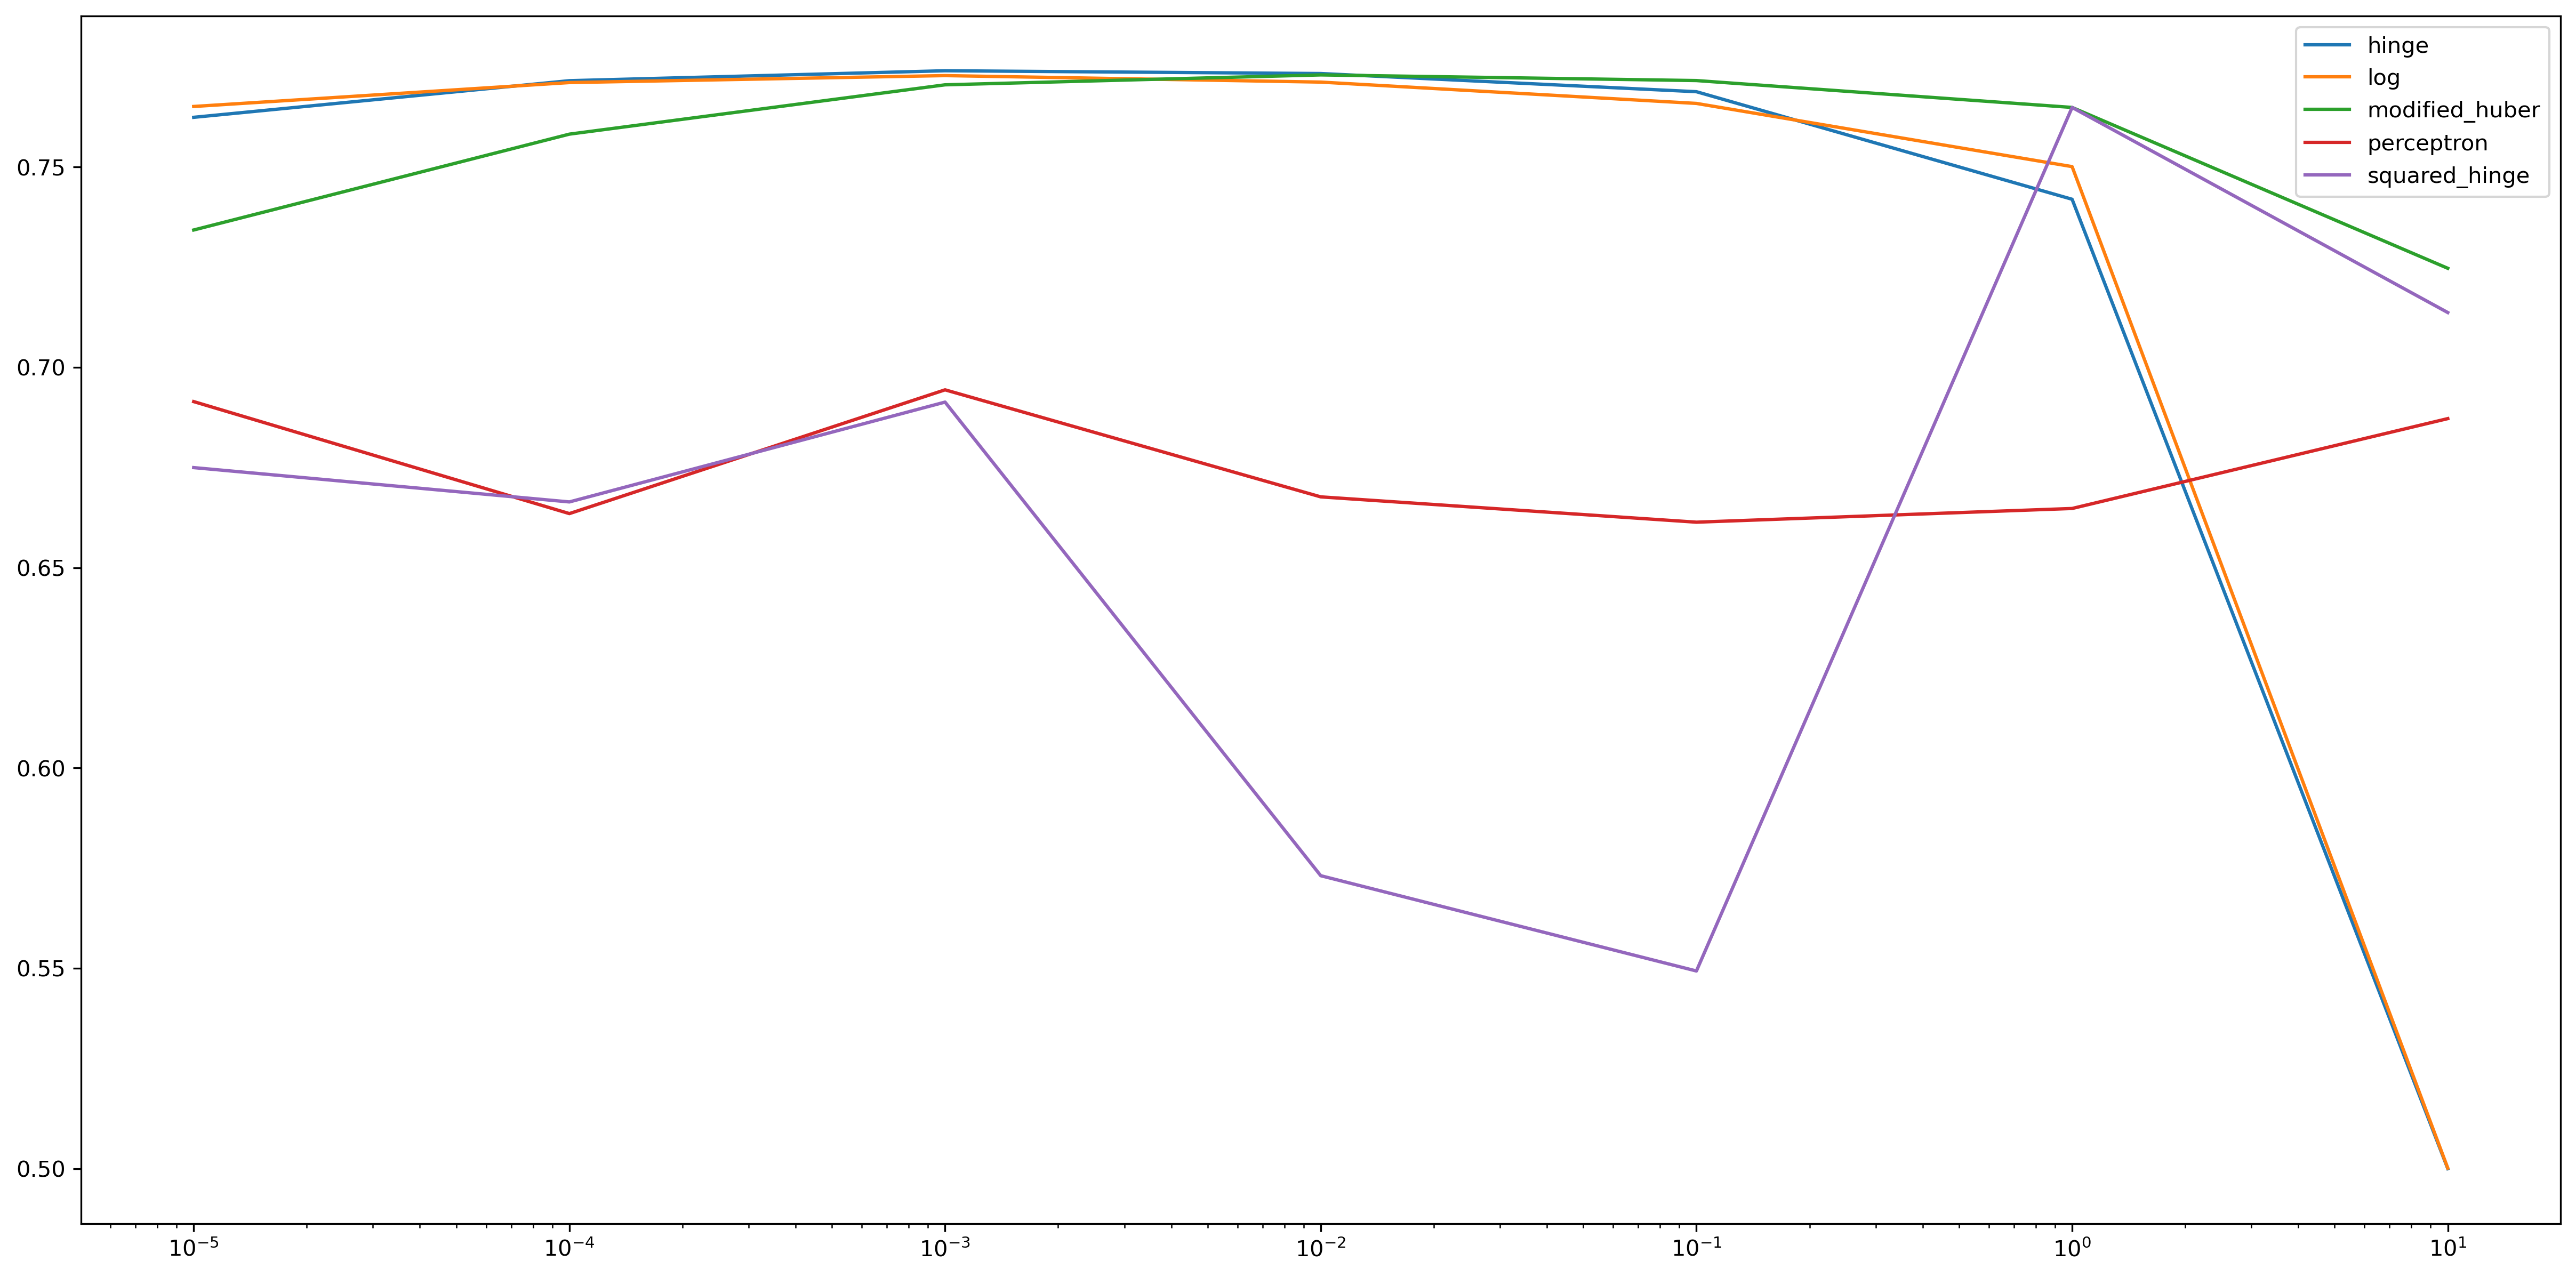

In [12]:
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
for loss_func, gb in cv_results.groupby("param_loss"):
    ax.plot(gb["param_alpha"], gb["mean_test_score"], label=loss_func)
ax.set_xscale("log")
ax.legend()
plt.show()

Wow.  We can easily see some pretty huge effects both of the choice of loss function (note how the Squared Hinge and Perceptron losses are pretty uniformly worse) and of the regularization strength.  The moral of the story: parameter tuning matters!

## Pick a more accurate model

Random Forests are a model that you should absolutely learn about and get comfortable with.  They work absurdly well for a huge range of tasks.  Let's see how a random forest with default settings does on this data.  Random forests are very parallelizeable, so we'll pass `n_jobs=4` to get basically a free 4x speed up (well, not completely free.  It'll use 4 CPU threads rather than 1):

In [13]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_jobs=4).fit(train_x, train_y)
print(f"Random Forest score: {metrics.accuracy_score(test_y, rf.predict(test_x)):.2%}")

Random Forest score: 94.04%
CPU times: total: 33.9 s
Wall time: 8.57 s


*Wow.*

For this data, a random forest absolutely trashes the SGD Classifier.  It's faster, and way more accurate with no feature selection or engineering!

This is a general trend you'll notice with *ensemble models* like Random Forests.  They tend to perform extremely well at default settings (but you should still tune the parameters for anything that's performance-critical!).  They're also very robust to outliers, tend to generalize pretty well, can be very fast (becuase they are extremely parallelizeable), they can give soft/probabilistic predictions, and they're just generally great.

In my experienece, random forests should *always* be one of the models you try.  They have very few downsides; they're rarely *the best* at any one thing they do, but they're easily *one of* the best models for everything they do.  Sometimes their accuracy will be about the same as some other model, but I don't think I've ever seen them be that much worse (unless they're being compared to a much more complex model like gradient boosting or a neural network).

## Tuning the parameters of a Pipeline

`Pipeline`s are estimators.  So just like an SGDClassifier or a Random Forest, they can have their parameters tuned.  What this means for a pipeline is this:
1. Each step in the pipeline is a parameter.  So you can experiment with whether a particular data preprocessing step helps or hurts.
2. Each parameter of the steps is a parameter.  So you can also tune the parameters of each step as you're experimenting.

The syntax for this is basically the same as the parameter tuning for a single model, with one exception.  If you want to tune the parameters within one of the steps, you need to reference it a little differently.

In [14]:
%%time
# Same Pipeline from before.
# The first element of each tuple--the string--is how we
# access the steps for grid searching.  To access the parameter
# of the thing in that step, e.g., to access the `loss` parameter
# of the SGDClassifier, we need to add a double underscore:
# `param_grid={"clf__loss": [values]}`
pipe = Pipeline(
    [
        ("interactions", PolynomialFeatures()),
        ("variance thresholding", VarianceThreshold()),
        ("f-test selection", SelectKBest(score_func=f_classif, k=100)),
        ("scaling", StandardScaler()),
        ("clf", SGDClassifier(tol=1e-5, random_state=0))
    ]
)
gs = GridSearchCV(
    estimator=pipe,
    param_grid={
        # See what happens if we don't scale the data; setting a pipeline
        # component to `None` will skip it.
        "scaling": [StandardScaler(), None],
        
        # try some different alpha values for the SGDClassifier.
        # Note the double underscore.
        "clf__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1],
    },
    cv=3,
    error_score=0,
    n_jobs=10,
    verbose=10,
)
gs.fit(train_x, train_y)
print(f"Accuracy: {gs.score(test_x, test_y):.2%}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Accuracy: 76.42%
CPU times: total: 17.5 s
Wall time: 2min 26s


We can also be super sneaky with this and use it to compare multiple alorithms!  And if we want to try different parameters for each of those algorithms, we can change what we pass to `param_grid`: just change it from a dictionary to a list of dictionaries; scikit-learn will do a grid search over each dictionary's combinations independently. The code below checks an SGDClassifier with hinge and log loss, and a Random Forest Classifier with gini and entropy criteria; it will check all the combinations of parameters listed in the first dictionary, and all the combinations in the second, but it will not mix-and-match between the two dictionaries.  (it's less confusing that I'm probably making it sound).

In [15]:
%%time
pipe = Pipeline(
    [
        ("interactions", PolynomialFeatures()),
        ("variance thresholding", VarianceThreshold()),
        ("f-test selection", SelectKBest(score_func=f_classif, k=100)),
        ("scaling", StandardScaler()),
        ("clf", SGDClassifier(tol=1e-5, random_state=0))
    ]
)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=[
        {
            # if you only have a single value, it still needs to be a list;
            # scikit-learn will try to iterate over these values.
            "clf": [SGDClassifier(tol=1e-5, random_state=0)],
            "clf__loss": ["hinge", "log"],
        },
        {
            "clf": [RandomForestClassifier()],
            "clf__criterion": ["gini", "entropy"],
        }
    ],
    cv=3,
    error_score=0,
    n_jobs=10,
    verbose=10,
)
gs.fit(train_x, train_y)
print(f"Accuracy: {gs.score(test_x, test_y):.2%}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Accuracy: 85.93%
CPU times: total: 50.5 s
Wall time: 2min 12s
